In [1]:
import mne
from mne.io import read_raw_edf
from mne import Epochs, pick_types, find_events
from mne.viz.topomap import plot_psds_topomap, plot_topomap
from mne.time_frequency import psd_multitaper, psd_welch
from scipy.signal import welch, lfilter

from mne.io import set_bipolar_reference

from mne.preprocessing import compute_proj_eog, ICA, ica_find_ecg_events, ica_find_eog_events
from mne.preprocessing import create_ecg_epochs, create_eog_epochs

from scipy.io import loadmat
from scipy.signal import periodogram, deconvolve
from scipy.misc import pade

from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

import csv, io, pickle

import numpy as np
from fooof import FOOOF, FOOOFGroup
from fooof.utils import combine_fooofs, get_settings

import argparse, time

import sys
from PIL import Image

from colour_search import load_montage, load_results, ssp_preprocessing, ica_preprocessing, combine_vertical_eog, fooof_channel_rejection


participants = ['ft10_p1', 'ft10_p2', 'ft10_p3', 'ft10_p4']
sessions = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
channel_names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D32', 'EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8']

channels_file = 'Glasgow_BioSemi_132.ced'

data_dir = '/data1/users/adoyle/eeg_test_retest/'

n_channels = 132
channel_names = channel_names[0:n_channels]
n_freqs = 256
n_events = 1100
n_bands = 5
n_participants = len(participants)
n_sessions = len(sessions)

# n_freqs_fooofed = 47027

fooof_group = FOOOFGroup()
freq = None

In [ ]:
montage = load_montage()

f_low = 0.1
f_high = 30

for participant_idx, participant in enumerate(participants):
    plt.close()
    
    for session_idx, session_name in enumerate(sessions):
        print('Participant', participant_idx + 1, '/', len(participants), 'session', session_idx + 1, '/',
              len(sessions))

        filename = data_dir + participant + '/' + participant + session_name + '.bdf'

        eeg = read_raw_edf(filename, montage=montage, eog=['EXG1', 'EXG2', 'EXG3', 'EXG4'], preload=True,
                           exclude=['EXG5', 'EXG6', 'EXG7', 'EXG8'])
        #         mne.set_eeg_reference(eeg, ref_channels='average', copy=True, projection=False)
      
    
        eeg.plot(start=1000.0, n_channels=128, block=True)
        print('bad channels:', eeg.info['bads'])
        eeg.interpolate_bads()
        
        eeg.save(data_dir + '/cleaned/' + participant + '/' + participant + session_name + '.bdf', overwrite=True)

Participant 1 / 4 session 1 / 10
Extracting EDF parameters from /data1/users/adoyle/eeg_test_retest/ft10_p1/ft10_p1s1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1348607  =      0.000 ...  2633.998 secs...
bad channels: []
No bad channels to interpolate. Doing nothing...
This filename (/data1/users/adoyle/eeg_test_retest//cleaned/ft10_p1/ft10_p1s1.bdf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Overwriting existing file.
Writing /data1/users/adoyle/eeg_test_retest/cleaned/ft10_p1/ft10_p1s1.bdf


<ipython-input-2-fff6b2c0f079>:22: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  eeg.interpolate_bads()
<ipython-input-2-fff6b2c0f079>:24: RuntimeWarning: This filename (/data1/users/adoyle/eeg_test_retest//cleaned/ft10_p1/ft10_p1s1.bdf) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  eeg.save(data_dir + '/cleaned/' + participant + '/' + participant + session_name + '.bdf', overwrite=True)


Closing /data1/users/adoyle/eeg_test_retest/cleaned/ft10_p1/ft10_p1s1.bdf [done]
Participant 1 / 4 session 2 / 10
Extracting EDF parameters from /data1/users/adoyle/eeg_test_retest/ft10_p1/ft10_p1s2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
The following EEG sensors did not have a position specified in the selected montage: ['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp']. Their position has been left untouched.
Reading 0 ... 1431039  =      0.000 ...  2794.998 secs...


<ipython-input-2-fff6b2c0f079>:16: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp']. Their position has been left untouched.
  exclude=['EXG5', 'EXG6', 'EXG7', 'EXG8'])


In [18]:
from fooof import FOOOF, FOOOFGroup
from scipy.signal import bilinear, remez
from mne.viz import plot_filter
from mne.time_frequency import psd_multitaper, psd_welch

montage = load_montage()

f_low = 1
f_high = 40

for participant_idx, participant in enumerate(participants):
    plt.close()
    
    for session_idx, session_name in enumerate(sessions):
        print('Participant', participant_idx + 1, '/', len(participants), 'session', session_idx + 1, '/',
              len(sessions))

        filename = data_dir + participant + '/' + participant + session_name + '.bdf'

        eeg = read_raw_edf(filename, montage=montage, eog=['EXG1', 'EXG2', 'EXG3', 'EXG4'], preload=True,
                           exclude=['EXG5', 'EXG6', 'EXG7', 'EXG8'])
        
        
        time_series = eeg.get_data(picks=list(range(128)))
        
        ff = FOOOF()
        ff.fit(time_series)
        
        

Participant 1 / 4 session 1 / 10
Extracting EDF parameters from /data1/users/adoyle/eeg_test_retest/ft10_p1/ft10_p1s1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1348607  =      0.000 ...  2633.998 secs...


ValueError: No data available to fit - can not proceed.

/home/users/adoyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/users/adoyle/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/users/adoyle/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/users/adoyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/users/adoyle/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/users/adoyle/anaconda3/lib/python3.6/site-packages/ipykernel

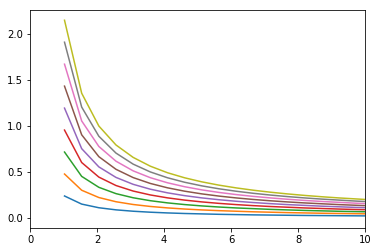

In [15]:
import numpy as np

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

freqs = np.linspace(0, 512, num=1000)

for x in range(1, 10):
    log = np.log10(freqs**x)
    bg = -10-log
    grad = np.gradient(log)
    plt.plot(freqs, grad)
    
plt.xlim([0, 10])
plt.show()


In [ ]:
ff = FOOOF()